### Import libraries

In [51]:
import pandas as pd
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import mean_squared_error
from pydub import AudioSegment
import pywt

### Load .tsv data 

In [44]:
common_voices_df = (pd.read_csv(r'E:\common_voices\uk\validated.tsv', sep='\t')[['path', 'gender']]).dropna()
common_voices_sample = common_voices_df.sample(n=3000, random_state=1)

In [58]:
def sex(x):
    if x == 'male': return 1
    else: return 0
common_voices_sample.gender = common_voices_sample.gender.apply(sex)

In [59]:
common_voices_sample

,path,gender
3265,common_voice_uk_23555662.mp3,0
38803,common_voice_uk_21862030.mp3,1
12581,common_voice_uk_23571007.mp3,0
14760,common_voice_uk_21567053.mp3,1
29109,common_voice_uk_23931241.mp3,1
...,...,...
29896,common_voice_uk_24287965.mp3,1
31630,common_voice_uk_22436288.mp3,1
10927,common_voice_uk_25292112.mp3,1
37898,common_voice_uk_21654288.mp3,1


### Extract features

In [11]:
def get_features(file_name):
    X, sample_rate = lr.load(file_name, sr=16000)

    stft = np.abs(lr.stft(X))
    result = np.array([])

    chroma = np.mean(lr.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))
    mel = np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    contrast = np.mean(lr.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, contrast))
    cA, cD = pywt.dwt(X, 'db1')
    result = np.hstack((result, [cA.mean(), cD.mean()]))
    return result

### Convert mp3 to wav 

In [13]:
for file in common_voices_sample['path'].values:
    sound = AudioSegment.from_mp3(r'E:\common_voices\uk\clips\\' + file)
    sound.export(r'E:\common_voices\uk\clips_wav\\' + file, format='wav')

In [14]:
files = lr.util.find_files(r'E:\common_voices\uk\clips_wav') 
files = np.asarray(files)
len(files)

3000

In [15]:
sample_pathes = []
for file in files:
    if (((file.split('\\')[4]).split('.'))[0] + '.mp3') in common_voices_sample.path.values:
        sample_pathes.append(file)

### Create dataframe for modeling

In [16]:
array = []
for k in range(len(sample_pathes)):
    features = get_features(sample_pathes[k])
    array.append(features)

In [45]:
len(array[0])

149

In [28]:
column_names = []
for j in range(147):
    if j < 12: column_names.append('chroma_' + str(j))
    elif j>=12  and j<140: column_names.append('mel_' + str(j-12))
    else: column_names.append('contrast_' + str(j-140))
column_names.append('wavelet_cA')
column_names.append('wavelet_cD')

In [34]:
dataframe = pd.DataFrame(array, columns=np.array(column_names))
dataframe['path'] = sample_pathes

In [60]:
merged_dataframe = pd.merge(dataframe, common_voices_sample, on='path')
merged_dataframe.shape

(3000, 151)

In [61]:
merged_dataframe

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,wavelet_cA,wavelet_cD,path,gender
0,0.609048,0.605545,0.591142,0.658247,0.687992,0.632058,0.630587,0.682306,0.709496,0.721459,...,15.339969,18.016537,18.107451,18.336659,18.940280,44.895433,1.859886e-06,1.541783e-08,common_voice_uk_20894281.mp3,1
1,0.520645,0.610680,0.656464,0.709239,0.749968,0.733003,0.678275,0.618974,0.636744,0.647777,...,14.528755,18.386380,15.973068,18.261029,19.390075,43.983836,1.881379e-05,7.233668e-09,common_voice_uk_20894334.mp3,1
2,0.300128,0.341838,0.305717,0.276773,0.258840,0.285728,0.327156,0.314603,0.288448,0.276976,...,16.861634,17.584720,19.463191,18.955218,17.713455,30.784422,2.225423e-05,-5.324117e-09,common_voice_uk_20900102.mp3,0
3,0.408150,0.475859,0.458274,0.422986,0.450028,0.454396,0.463918,0.513978,0.511510,0.506202,...,18.522396,21.379026,19.832804,19.955215,21.160639,44.742829,-7.342162e-06,-4.468617e-09,common_voice_uk_20900142.mp3,0
4,0.314130,0.318948,0.289681,0.297413,0.286962,0.283445,0.330429,0.424861,0.392418,0.300347,...,18.590908,19.758513,20.403430,19.618448,20.427730,35.960112,2.512027e-06,1.243918e-09,common_voice_uk_20900163.mp3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.493694,0.506249,0.518980,0.545611,0.529672,0.559269,0.662264,0.817417,0.804382,0.655630,...,18.459355,18.865863,17.428354,17.141690,23.234875,37.296973,-1.064667e-05,-3.639022e-09,common_voice_uk_27182939.mp3,1
2996,0.562997,0.550991,0.594704,0.605965,0.603984,0.586613,0.668723,0.832074,0.815481,0.724853,...,17.639356,18.433562,16.728470,16.967880,21.408539,36.135334,-1.746125e-07,-8.768373e-08,common_voice_uk_27182940.mp3,1
2997,0.482830,0.451846,0.480946,0.563314,0.561271,0.546303,0.637646,0.718286,0.796869,0.733928,...,17.059426,17.255037,17.396775,17.180296,21.178072,38.529394,-1.383973e-04,-1.035078e-07,common_voice_uk_27182988.mp3,1
2998,0.543115,0.529522,0.566431,0.503769,0.502115,0.603018,0.722291,0.827062,0.748753,0.644281,...,17.960220,18.392437,17.480815,17.532458,21.792591,36.221328,-4.715814e-05,-2.104423e-08,common_voice_uk_27183486.mp3,1


In [62]:
X_train, X_test, y_train, y_test = train_test_split(merged_dataframe.drop(columns = ['path', 'gender']),
                                                    merged_dataframe.gender, test_size=0.2, random_state=1)
parametrs = {'n_estimators':range(5,41,5), 'max_depth':range(1,9,2),
    'min_samples_leaf':range(1,8), 'min_samples_split':range(2,4)}
voice_rf = RandomForestClassifier(random_state=0)
search = GridSearchCV(voice_rf, parametrs, n_jobs=-1, cv=3)
search.fit(X_train,y_train)
best_voice_forest = search.best_estimator_

predictions = best_voice_forest.predict(X_test)
(predictions == y_test.to_numpy()).sum()

578

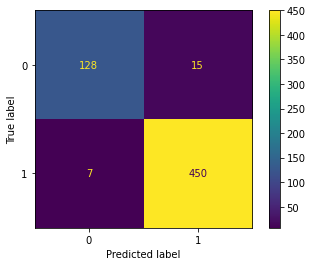

In [64]:
plot_confusion_matrix(best_voice_forest, X_test, y_test)  
plt.show()

In [66]:
print("Mean squared error: %.2f"
    % mean_squared_error(y_test, predictions))

Mean squared error: 0.04
